# <b><center>W261 Final Project - Criteo Click Through Rate Prediction</center></b>

<center><b>W261 Team 10</b></center>

<center>Youzhi (Chloe) Wu, Chun-Jen (Curtis) Lin, Eddie Zhu, Kai Qi Lim</center>

# **1. Question Formulation**

Marketing campaigns cost money. It is of every company's business interest to launch a targeted and effective marketing campaign. An important metric to gauge the performance of each digital advertisement is click through rate (CTR), which is a ratio to show "how often people who see your ad end up clicking it" <sup>(1)</sup>. Therefore, the purpose of this project is to establish a model to accurately predict CTR, and more importantly, a model with scalability to be applied to large volume of data. It will help companies to improve the effectiveness of their digital marketing campaigns, and to maximize their ROI.


Specifically, the question we want to answer is: **based on a set of features, would the advertisement be clicked?** Our dataset is obtained through Kaggle Display Advertising Challenge launched by CriteoLabs back in 2014. We downloaded `train.csv` (with a size of approximately 12 GB) from Criteo <sup>(2)</sup>. In this `csv` file, each row corresponds to a display ad served by Criteo, with 
- target variable as the first column:
  - `1` for clicked, and 
  - `0` for non-clicked, and 
- the rest being feature variables:
  - `I1` to `I13`: A total of 13 columns of integer features.
  - `C1` to `C26`: A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes.


In this report, 
* We first split full data in `train.csv` into our training (80%) and testing data (20%); within the training dataset, we randomly sample 1,000 records to be our toy dataset;
* conduct EDA on our toy dataset; 
* select a model based off the takeaways from our EDA; 
* explain the mathematical theory behind Logistic Regression model; 
* to clearly articulate the mathematical mechanisms behind Logistic Regression model, we build a homegrown Logistic Regression model, create a mini toy dataset, and apply the homegrown model to our mini toy dataset;
* apply multiple techniques of feature engineering on our toy dataset (1,000 records);  
* establish a Spark ML Logistic Regression model and apply to the toy dataset and eventually the full dataset;
* evaluate our model performance by calculating its accuracy and log loss;
* conclude our report with discussions of our challenges, and application of course concepts. 

Certain limitations are noted: 
- Since the `train.csv` provided by Criteo only corresponds to its traffic over a period of 7 days, it is possible that the data may not be representative enough (i.e. holiday season click through activities could be different than non-holiday season). In such case, our model may not generalize well. 
- The semantic of feature variables are not made public by Criteo. Furthermore, the values of all categorical variables are encrypted. Feature engineering is conducted solely based upon mathematical characteristics of each variable, without any industry knowledge involved. If feature names as well as values were to be known, our feature engineering could have been done in a more effective and sensible manner. 

## **1.1 Setup**

### (1) Install and import packages

In [ ]:
!pip install pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark-dist-explore
!pip install -U -q PyDrive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from random import sample
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.mllib.stat import Statistics
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoderModel
from pyspark.ml.feature import PCA, PCAModel
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Normalizer
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import log

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "finalproject_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [ ]:
spark

In [ ]:
# package for loading file in Apache Parquet Format
import pyspark
import pyarrow.parquet as pq

In [ ]:
# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

### (2) Map google drive for data import

Our notebook is created and coompleted using Google Colaboratory. `train.csv` is loaded in our shared Google Drive folder. Therefore, we need to set up Google Drive authentication to read in datasets. 

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### (3) Import and export data

We converted `train.csv` to `train.txt`.

In [ ]:
test_csv_link = 'https://drive.google.com/open?id=1U1kq5eK9talUX6hwg1XWm2JlIMiOhhg_'
train_csv_link = 'https://drive.google.com/open?id=1YLDrDVHfi1fJMNJCbtyHHrayuHWVQ0A5'

_, test_id = test_csv_link.split('=')
_, train_id = train_csv_link.split('=')
# print (test_id) # Verify that you have everything after '='
print (train_id) # Verify that you have everything after '='

downloaded_test = drive.CreateFile({'id':test_id})
downloaded_train = drive.CreateFile({'id':train_id}) 
downloaded_test.GetContentFile('test.txt')
downloaded_train.GetContentFile('train.txt')

1YLDrDVHfi1fJMNJCbtyHHrayuHWVQ0A5


### (4) Split full dataset (train.txt) to train and test (80% - 20%) 


We splited full dataset (train.txt) to train and test (80% - 20%). Furthermore, we randomly sampled 1,000 records from training dataset, and created it as toy dataset. 

Notes: codes commented out to avoid accidental changes to these data imports

In [ ]:
## the train.txt is too big to read with pandas, there the 80%-20% split will carry out by Spark
dataRDD = sc.textFile('train.txt')

In [ ]:
## total count of train.txt dataset
full_data_count = dataRDD.count()
print('Total line of full dataset: %s' %full_data_count)

Total line of full dataset: 45840617


In [ ]:
## create trainRDD and devRDD (80%-20%)
trainRDD, devRDD = dataRDD.randomSplit([0.8,0.2], seed = 5)

# random sample about 1000 examples from trainRDD as toyRDD
toyRDD = trainRDD.sample(False, 0.00003).cache()

In [ ]:
## create a list of toy dataset
def parse(line):
  context = line.split('\t')
  yield(context)

# run Spark job
toy_data = toyRDD.flatMap(parse).collect()

In [ ]:
## write toy dataset as toy.txt
df = pd.DataFrame(toy_data)
df.to_csv('/content/drive/My Drive/Colab Notebooks/dac/toy.txt', sep=',', index=False)

### (5) Load toy samples from Google drive

In [ ]:
## load toy dataset (1000 data points) from Google drive
toy_csv_link = 'https://drive.google.com/open?id=1UiHJ4XDJK6QxkrfD_2azcjTiWtPx5je2'

_, toy_id = toy_csv_link.split('=')

downloaded_toy = drive.CreateFile({'id':toy_id})
downloaded_toy.GetContentFile('toy.txt')

We further created 2 larger toy datasets (each with 10,000 records). These datasets are created for EDA pruposes, in order to verify whether certain trends are common in all random samples. These sample datasets also use for examine the regression model is the small sacle.

In [ ]:
## load 3 toy dataset (10000 data points) from Google drive
toy_10000_1_link = 'https://drive.google.com/open?id=1tlO0J4Nmlmn34h0TcieddtYE6L1sVktX'
toy_10000_2_link = 'https://drive.google.com/open?id=1sa-Lp7eOh3X3fhXKr4gX0wEUA0YZbhJZ'

_, toy_id1 = toy_10000_1_link.split('=')
_, toy_id2 = toy_10000_2_link.split('=')

downloaded_toy1 = drive.CreateFile({'id':toy_id1})
downloaded_toy1.GetContentFile('toy10000-1.txt')

downloaded_toy2 = drive.CreateFile({'id':toy_id2})
downloaded_toy2.GetContentFile('toy10000-2.txt')

In [ ]:
## read file into pandas dataframe
with open('toy.txt') as toy:
  toy = pd.read_csv(toy)

# **2. EDA & Discussion of Challenges​** 


## **2.1 First view of the raw dataset**

* Column 0 represents the target variable which takes on the value of either 1 (clicked) or 0 (did not click). 
* Columns 1 to 13 are feature variables with numeric fields 
* Columns 14 to 39 are feature variables that are categorical in nature

In [ ]:
# This is to read the text file into spark 
# so that we can tranform it into parquet file for more efficient processing
toyDataFrame = spark.read.format("csv").option("header", True).load('toy.txt')

toyDataFrame.show()

+---+----+---+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   1|  2|   3|   4|    5|   6|   7|  8|   9|  10|  11|  12|  13|      14|      15|      16|      17|      18|      19|      20|      21|      22|      23|      24|      25|      26|      27|      28|      29|      30|      31|      32|      33|      34|      35|      36|      37|      38|      39|
+---+----+---+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   3|  5|   8|  32|  766|  93|  25| 47| 326|   1|   4|null|  44|05db9164|38a947a1|4

The datatype of each column is `string`. We would need to do data type conversion before featuring engineering and modeling. 

In [ ]:
toyDataFrame.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 1: string (nullable = true)
 |-- 2: string (nullable = true)
 |-- 3: string (nullable = true)
 |-- 4: string (nullable = true)
 |-- 5: string (nullable = true)
 |-- 6: string (nullable = true)
 |-- 7: string (nullable = true)
 |-- 8: string (nullable = true)
 |-- 9: string (nullable = true)
 |-- 10: string (nullable = true)
 |-- 11: string (nullable = true)
 |-- 12: string (nullable = true)
 |-- 13: string (nullable = true)
 |-- 14: string (nullable = true)
 |-- 15: string (nullable = true)
 |-- 16: string (nullable = true)
 |-- 17: string (nullable = true)
 |-- 18: string (nullable = true)
 |-- 19: string (nullable = true)
 |-- 20: string (nullable = true)
 |-- 21: string (nullable = true)
 |-- 22: string (nullable = true)
 |-- 23: string (nullable = true)
 |-- 24: string (nullable = true)
 |-- 25: string (nullable = true)
 |-- 26: string (nullable = true)
 |-- 27: string (nullable = true)
 |-- 28: string (nullable = true)
 |-- 29: string (nu

## **2.2 Histogram of numeric variables**

From the histograms of all numeric variables (1 to 13), we can see that 
- nearly all variables present high degree of skewness, with very high counts at the low values and low counts at high values. As a result, we need to run log transformation to reduce the skewness. 
- column 10 is a categorical variable rather than numeric. In feature engineering steps, we will treat it as categorical variable. 
- the scale of these columns are at different magnitude, with certain columns under 5 or 50, and certain columns in the range of hundreds, thousands, and even 1,000,000. As such, we also need to apply normalization/standardization. 

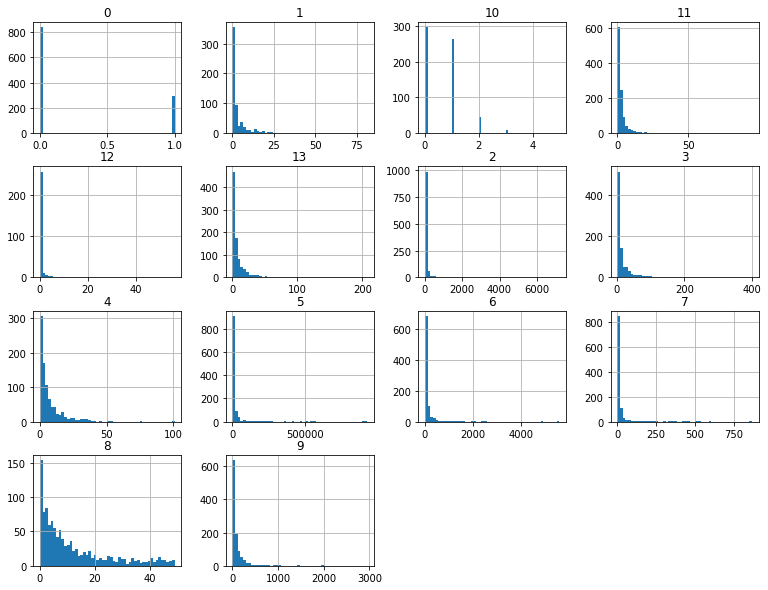

In [ ]:
# show histogram of all numerical features. 
# Some are actually cateogrical and need to be converted. 
# Some are skewed and need to be normalized
toy.hist(figsize=(13,10),bins=50)
plt.show()

## **2.3 Scatterplot to see outliers**

From the scatterplots of all numeric variables (1 to 13), we can see that 
- The values of Column 8 is evidently spread out. 
- On the contrary, Column 12 and 13 have a higher degree of concentration.
- Column 1 to 7, 9 and 11 are in the middle ground.   
- For Column 10, most data points have value of 0, 1 and 2. A few data points have value of 3. An extreme outlier has a value of 5.  

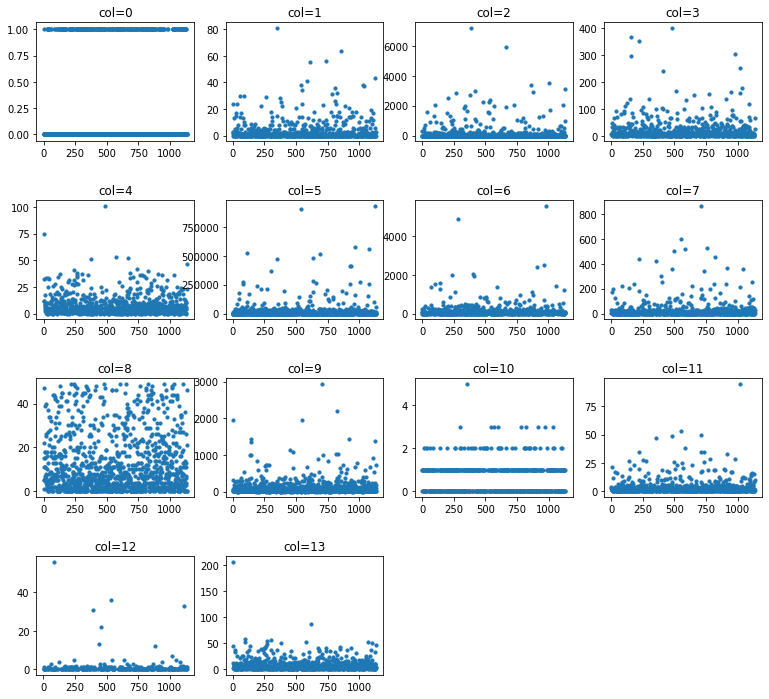

In [ ]:
# Scatterplot to see outliers
x = range(len(toy))

fig = plt.figure(figsize=(13, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(14):
  y = toy.iloc[:,i]
  ax = plt.subplot(4,4,i+1)
  ax.scatter(x,y, s=10)
  ax.set_title("col={}".format(i))

## **2.4 Read toy data into parquet format for additional EDAs**

Parquet is a serverless file format which is highly optimized. For larger dataset, we should consider using this file format for scalability. After saving our dataset into parquet file, we read in the data from parquet file. In addition, we conducted further EDA on three larger toy sets (each with 10,000 records) to verify whether:
- skewness are common to all toy datasets;
- large scale of value difference in numeric fields are present in all toy datasets;
- the counts of records with null value in each column for all toy datasets. We can see that for certain columns, majority of records are null. In this case, we should consider remove these columns from our modeling. 

In [ ]:
# write parquet file from the dataframe 
toyDataFrame.write.parquet('toy_df.parquet')

In [ ]:
# read parquet file. 
# Parquet file is a serverless data format that is highly optimized. 
# We can use spark sql or dataframe to read and analyze the parquet file. 
toy_df = sqlContext.read.parquet('toy_df.parquet')
toy_df.show()

+---+----+---+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   1|  2|   3|   4|    5|   6|   7|  8|   9|  10|  11|  12|  13|      14|      15|      16|      17|      18|      19|      20|      21|      22|      23|      24|      25|      26|      27|      28|      29|      30|      31|      32|      33|      34|      35|      36|      37|      38|      39|
+---+----+---+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   3|  5|   8|  32|  766|  93|  25| 47| 326|   1|   4|null|  44|05db9164|38a947a1|4

In [ ]:
print("Number of lines in toy data: %s" %toy_df.count())

Number of lines in toy data: 1136


In [ ]:
# check the summary statistics of numeric columns. 
# Some of the columns are in much large scales than other ones. 
# Potentially need log transformation
toy_df.select(['0','1','2','3','4','5','6','7','8','9','10','11','12','13']).summary().show()

+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|                 0|                1|                2|                 3|                 4|                 5|                 6|                7|                 8|                 9|                10|               11|                12|                13|
+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|              1136|              614|             1136|               882|               887|              1107|               885|             1076|              1136|       

In [ ]:
# Check for count of n/a in every column. 
# Need to decide how to deal with the n/a. 
# Do we fill it with null or do we remove them. 

toy_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in toy_df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|  1|  2|  3|  4|  5|  6|  7|  8|  9| 10| 11| 12| 13| 14| 15| 16| 17| 18| 19| 20| 21| 22| 23| 24| 25| 26| 27| 28| 29| 30| 31| 32| 33| 34| 35| 36| 37| 38| 39|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|  0|522|  0|254|249| 29|251| 60|  0| 60|522| 60|849|249|  0|  0| 42| 42|  0|143|  0|  0|  0|  0|  0| 42|  0|  0|  0| 42|  0|  0|484|484| 42|879|  0| 42|484|484|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



In [ ]:
# check additional dataframe for EDA
toy100001_df = spark.read.format("csv").option("header", True).load('toy10000-1.txt')
toy100001_df.show()

+---+----+---+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   1|  2|   3|   4|    5|   6|   7|  8|   9|  10|  11|  12|  13|      14|      15|      16|      17|      18|      19|      20|      21|      22|      23|      24|      25|      26|      27|      28|      29|      30|      31|      32|      33|      34|      35|      36|      37|      38|      39|
+---+----+---+----+----+-----+----+----+---+----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  1|   5| 44|  30|   4|    0|   0|   5|  4|   4|   1|   1|null|   0|8cf07265|c1384774|7

In [ ]:
print("Number of lines in toy 10001 data: %s" %toy100001_df.count())

Number of lines in toy 10001 data: 10849


In [ ]:
toy100001_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in toy100001_df.columns]).show()

+---+----+---+----+----+---+----+---+---+---+----+---+----+----+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+---+----+----+
|  0|   1|  2|   3|   4|  5|   6|  7|  8|  9|  10| 11|  12|  13| 14| 15| 16| 17| 18|  19| 20| 21| 22| 23| 24| 25| 26| 27| 28| 29| 30| 31|  32|  33| 34|  35| 36| 37|  38|  39|
+---+----+---+----+----+---+----+---+---+---+----+---+----+----+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+---+----+----+
|  0|4866|  0|2344|2381|270|2383|480|  4|480|4866|480|8344|2381|  0|  0|371|371|  0|1282|  0|  0|  0|  0|  0|371|  0|  0|  0|371|  0|  0|4766|4766|371|8302|  0|371|4766|4766|
+---+----+---+----+----+---+----+---+---+---+----+---+----+----+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+---+----+----+



In [ ]:
toy100002_df = spark.read.format("csv").option("header", True).load('toy10000-2.txt')
toy100002_df.show()

+---+----+---+----+----+-----+----+---+---+---+----+---+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   1|  2|   3|   4|    5|   6|  7|  8|  9|  10| 11|  12|  13|      14|      15|      16|      17|      18|      19|      20|      21|      22|      23|      24|      25|      26|      27|      28|      29|      30|      31|      32|      33|      34|      35|      36|      37|      38|      39|
+---+----+---+----+----+-----+----+---+---+---+----+---+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|   0|  0|   6|null| 2972|  26|  2|  3| 11|   0|  1|   0|null|68fd1e64|80e26c9b|9dd3c4fc|a09f

In [ ]:
print("Number of lines in toy 10002 data: %s" %toy100002_df.count())

Number of lines in toy 10002 data: 11131


In [ ]:
toy100002_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in toy100002_df.columns]).show()

+---+----+---+----+----+---+----+---+---+---+----+---+----+----+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+---+----+----+
|  0|   1|  2|   3|   4|  5|   6|  7|  8|  9|  10| 11|  12|  13| 14| 15| 16| 17| 18|  19| 20| 21| 22| 23| 24| 25| 26| 27| 28| 29| 30| 31|  32|  33| 34|  35| 36| 37|  38|  39|
+---+----+---+----+----+---+----+---+---+---+----+---+----+----+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+---+----+----+
|  0|5070|  0|2457|2449|287|2426|463|  5|463|5070|463|8492|2449|  0|  0|398|398|  0|1373|  0|  0|  0|  0|  0|398|  0|  0|  0|398|  0|  0|4893|4893|398|8582|  0|398|4893|4893|
+---+----+---+----+----+---+----+---+---+---+----+---+----+----+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+----+----+---+----+---+---+----+----+



## **2.5 Heatmaps to see similarity and correlations**

From the null count and heatmap visualization, we see certain similarity in some columns. The following columns tend to be null in the same rows:
* Col 1, 10 
* Col 3, 4, 6, 13
* Col 7, 9, 11
* Col 16, 17, 25 and 29
* Col 32, 33, 38, 39 
* Col 12, 35: for these two columns, half of the rows are empty. Which bring up a question on whether they would be useful for prediction. We may need to consider removing these 2 features from our model. 

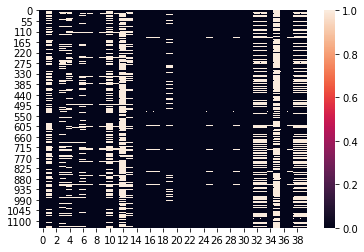

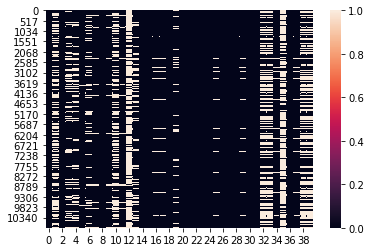

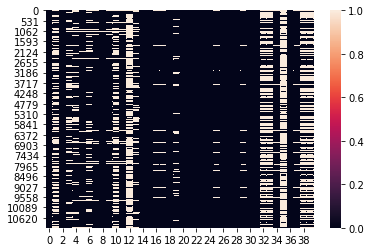

In [ ]:
# Heatmap function for specified columns
pandas_df = toy_df.toPandas()
pandas_df10001 = toy100001_df.toPandas()
pandas_df10002 = toy100002_df.toPandas()

def col_heat(dataframe, columns): 
    temp_df = dataframe.iloc[:,columns]
    temp_df_heatmap = temp_df.isnull()
    sns.heatmap(data=temp_df_heatmap)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.show()

# use pandas and seaborn to visualize the missing value issue. 
# For numeric columns, we can fillna with mean. 
# We need to think about how to deal with the na in the non-numeric columns

all_col = range(40)
# col_heat(all_col)

# plot 3 sample datasets
col_heat(pandas_df, all_col)
col_heat(pandas_df10001, all_col)
col_heat(pandas_df10002, all_col)

Next, we want to inspect the correlations between variables further by examing their correlation matrix and correlation heatmaps. From the correlation heatmaps, we can see that:
- Column 7 and 11 have strong positive correlation, 
- Column 10 and 1 have strong positive correlation, 
- Column 4 and 13 have strong positive correlation. 

Therefore, we would need to consider dropping one of the correlated columns during our feature engineering step. 

In [ ]:
# fill na with 0
df_nona = pandas_df.fillna(0)

In [ ]:
# correlation matrix 
df_13 = df_nona.iloc[:,0:14]

In [ ]:
# change all columns to numeric 
col = df_13.columns
df_13[col] = df_13[col].apply(pd.to_numeric, errors='coerce')

In [ ]:
# find pairwise correlations between columns 
corr = df_13.corr()
corr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.071663,0.031518,-0.016930,-0.022359,-0.077261,-0.053731,0.006213,-0.021787,-0.016119,0.135189,0.083508,-0.039319,-0.097807
1,0.071663,1.000000,0.008527,0.066571,0.133098,-0.093329,-0.083124,0.481910,0.210609,0.121597,0.660884,0.371547,0.053320,0.072102
2,0.031518,0.008527,1.000000,-0.032088,-0.086562,0.085795,-0.016741,-0.007519,-0.027295,0.006229,0.022320,-0.009925,-0.005648,-0.055749
3,-0.016930,0.066571,-0.032088,1.000000,0.330984,-0.030508,0.000704,-0.033776,0.262367,-0.011754,0.052273,-0.037593,0.000407,0.200882
4,-0.022359,0.133098,-0.086562,0.330984,1.000000,-0.108690,-0.008380,0.038702,0.537259,0.208870,0.183565,0.070951,0.024418,0.735196
5,-0.077261,-0.093329,0.085795,-0.030508,-0.108690,1.000000,0.019449,-0.078353,-0.151915,-0.082124,-0.153634,-0.116215,-0.029048,-0.086887
6,-0.053731,-0.083124,-0.016741,0.000704,-0.008380,0.019449,1.000000,-0.052143,0.007327,0.137297,-0.142268,-0.053994,-0.008339,0.047439
7,0.006213,0.481910,-0.007519,-0.033776,0.038702,-0.078353,-0.052143,1.000000,0.115958,0.387017,0.338522,0.761762,0.141419,0.027560
8,-0.021787,0.210609,-0.027295,0.262367,0.537259,-0.151915,0.007327,0.115958,1.000000,0.255121,0.231352,0.175146,0.107537,0.462657
9,-0.016119,0.121597,0.006229,-0.011754,0.208870,-0.082124,0.137297,0.387017,0.255121,1.000000,0.098649,0.466354,0.074364,0.314604


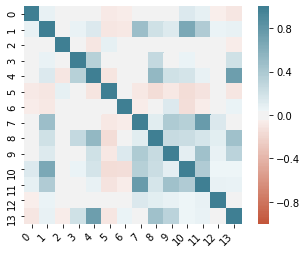

In [ ]:
# draw heatmap of the pairwise correlations. 
# Results indicate that 7 and 11, 10 and 1, 4 and 13 have strong positive correlation. 
# Need to exam multicollinearity
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## **2.6 Uniqueness percentage in categorical fields**

For categorical fields (Columns 14-39), we further check the counts of unique categories for each feature. The following columns showing high counts of unique categories (more than 50% uniqueness):
- 16, 17, 20, 23, 24, 25, 26, 28, 29, 31, 34, 37

Assuming a variable with 100% uniqueness, which means every row has its own category for this variable. It would not help in our modeling by distinguishing our data points to different groups. As such, we assume that a variable with high uniqueness percentage may contribute less information compared to those with lower uniqueness. As the dataset gets larger, feature dimension reduction becomes more important in order for our modeling to scale. Thus, in our feature engineering step, we would like to consider removing categorical variables with more than 50% uniqueness.  

In [ ]:
# Categorical fields: columns 14-39 
# ===> Check number of unique categories for each feature
df_14_39 = df_nona.iloc[:,14:40]

for col in range(df_14_39.shape[1]):
    temp_df = df_14_39.iloc[:,col]
    print("no. of data in col {}: {}".format(temp_df.name, len(temp_df)))
    print("no. of unique in col {}: {}".format(temp_df.name, len(temp_df.unique())))
    print("% of uniqueness {}: {}%".format(temp_df.name, (round(len(temp_df.unique())/len(temp_df)*100,2))))
    print("=======\n")

no. of data in col 14: 1136
no. of unique in col 14: 60
% of uniqueness 14: 5.28%

no. of data in col 15: 1136
no. of unique in col 15: 211
% of uniqueness 15: 18.57%

no. of data in col 16: 1136
no. of unique in col 16: 863
% of uniqueness 16: 75.97%

no. of data in col 17: 1136
no. of unique in col 17: 732
% of uniqueness 17: 64.44%

no. of data in col 18: 1136
no. of unique in col 18: 27
% of uniqueness 18: 2.38%

no. of data in col 19: 1136
no. of unique in col 19: 8
% of uniqueness 19: 0.7%

no. of data in col 20: 1136
no. of unique in col 20: 785
% of uniqueness 20: 69.1%

no. of data in col 21: 1136
no. of unique in col 21: 34
% of uniqueness 21: 2.99%

no. of data in col 22: 1136
no. of unique in col 22: 2
% of uniqueness 22: 0.18%

no. of data in col 23: 1136
no. of unique in col 23: 667
% of uniqueness 23: 58.71%

no. of data in col 24: 1136
no. of unique in col 24: 629
% of uniqueness 24: 55.37%

no. of data in col 25: 1136
no. of unique in col 25: 835
% of uniqueness 25: 73

## **2.7 Takeaways from EDA**  
Our EDA was conducted on 4 toy datasets, one with 1,000 records, the other three each with 10,000 records. Even though our EDA has not been run on full dataset, we could already see some challenges in modeling based off the EDA results:
- The numeric data are highly skewed. Log transformation should be applied.
- The value scale among numeric variables present significant difference. Normalization/standardization should be considered. 
- There are large amount of null values in both numeric and categorical fields. We need to come up with an approach in handling these null values. Should they be removed, replaced with zeros, or replaced with mean? Should we handle numeric and categorical fields differently? 
- Both the semantics and the values of categorical variables are unknown. To build them into our model, we need to perform certain encoding in order to convert hashed strings to numbers. One hot encoding would be applied to these categorical variables. The biggest challenge we anticipate in doing so would be: 
  - when applying to full dataset, because there could be large number of categories for each variable, one hot encoding would further expand our features to a even more substantial amount. 
  - with such a considerable size of features, it could lead to memory issue at our modeling stage. 
- Feature reduction becomes a key in resolving this potential memory issue. Approaches we could take in next stage would be:
  - Removing features with high percentage (more than 50%) of null values;
  - Dropping similar columns, or correlated columns;
  - Removing features with high percentage (more than 50%) of uniqueness;
  - Running PCA on our engineered dataset to further reduce feature dimensions. 


# **3. Algorithm Explanation​**



## **3.1 Model selection**

With the outcome variable being binary, taking on values of only 1 or 0, and EDA showing that the dataset contain both numeric and categorical fields, logistic regression model was selected. A logistic model trained on the training data will be used for prediction on the developmental set, and finally test set.

## **3.2 Set up mini toy dataset**
In this section, we set up a mini toy dataset with similar type of fields to demonstrate the math behind the algorithm. Suppose we want to predict whether an animal is a cat (1) or dog (0) based on weight in lbs, length in inches and colour of fur. 

The mini toy dataset has four fields:
* Column 1: target variable - cat (1) or dog (0)
* Column 2: weight in lbs (numeric)
* Column 3: length in inches (numeric) 
* Column 4: colour of fur (categorical)

The following transformations will be applied to the mini toy dataset before performing logistic regression:
*   Log transformation
*   One hot encoding
*   Normalization
*   Augmentation



After one-hot encoding, the dataset would expand into 5 fields:

* Column 1: target variable - cat (1) or dog (0)
* Column 2: weight in lbs
* Column 3: length in inches  
* Column 4: fur_brown (1 or 0)
* Column 5: fur_black (1 or 0)

In [ ]:
%%writefile mini_toy.txt
1 7.9 18.1 brown 
0 44.1 20 black 
0 55.1 27.5 brown 
1 8.2 17.5 brown 
1 9.0 18.5 black 

Overwriting mini_toy.txt


## **3.3 Logistic regression math**

Logistic regression is a statistical model that uses a logistic function to model a binary dependent variable <sup>(3)</sup>. Training data is used to fit a logistic regression model to obtain model coefficients. Then, the test data is put into this model to predict whether the outcome is 1 or 0, in this case, whether the animal is cat or dog.

It assumes that <sup>(4)</sup>:
* The independent variables are independent of each other so that the model has no multi-collinearity.
* The independent variables are linearly related to the log odds.
* Sample size is sufficiently large.



In our mini toy set, the probability that an animal is cat given a set of features would be:

$$ P(y=1|x)= \frac{1}{1 + e^{-({\theta}\cdot\mathbf{x}^{'T}_i)}}$$

And the probability that the animal is dog would be 1 minus the term above:

$$ P(y=0|x)= 1 - \frac{1}{1 + e^{-({\theta}\cdot\mathbf{x}^{'T}_i)}}$$

where $x$ refers to the features weight, length, fur_brown and fur_black.

The predicted output is in the form of probability. Since we are making a binary prediction, a probability higher than 0.5 would be predicted as 1 (cat), and less than 0.5 predicted as 0 (dog). 

### (1) Loss Function

Instead of mean-squared error, we use log loss as the cost function for logistic regression <sup>(5)</sup>:

$$J(\theta) = - \frac{1}{n} \sum_{i=1}^{n} [y^{i}\cdot{log(h_\theta}(x_i)) + (1-y^{i})\cdot{log(1-h_\theta}(x_i))]$$

where, $$\boldsymbol{h_\theta}(x_i) = \frac{1}{1 + e^{-(\boldsymbol{\theta}\cdot\mathbf{x}^{'T}_i)}}$$

$$
\boldsymbol{\theta} :=
\begin{bmatrix}
\mathbf{w}\\
b
\end{bmatrix}
$$


### (2) Gradient Descent
Gradient is shown as below <sup>(6)</sup>:
$$
g(\theta_j) = \frac{\partial}{\partial \theta_j}J(\theta) = \sum_{i=1}^{n} (\boldsymbol{h_{\theta}}(x^i_j)-y^i)x^i_j
$$

Gradient update:
$$
\theta_{j+1} = \theta_j - \alpha \sum_{i=1}^{n} (\boldsymbol{h_{\theta}}(x^i_j)-y^i)x^i_j
$$

where $\alpha$ is the learning rate. 


### (3) Binary Predictions
For binary logistic regression problem, by default, if the parameterized function $\boldsymbol{h_\theta}(x_i)$ result is larger than $0.5$, then $\hat{y_i}$ is predicted as class 1; else, predicted as class 0. 

# **4. Algorithm Implementation**


## **4.1 Homegrown Logistic Regression**

In this section, we developed functions to implement a "homegrown" algorithm on the mini toy dataset:

- `parse`: splits fields and target variable and to log-transform the numeric fields
- `onehot`: one-hot encode the specified categorical fields
- `normalize`: scale and center data around the mean of each feature
- `AugmentRDD`: adds a bias feature of 1 at index 0 and weights to parameter function. Weights refer to model coefficients with bias at index 0
- `LRLoss`: compute loss for logistic regression based on the input dataRDD and current model.
- `GDUpdate`: perform one Logistic Regression gradient descent step/update.
- `LRGDFit`: perform nSteps iterations of Logistic Regression gradient descent, track loss on train set, and return current model as well as its corresponding train loss.
- `LRGDPredict`: perform prediction based on Logistic Regression weights.


In [ ]:
# load data 
data = sc.textFile("mini_toy.txt")   

In [ ]:
# helper function to 
# (1) split fields and target
# (2) log-transform the numeric fields
num_col = [1,2]
str_col = [3]

def parse(line):
    """
    Map str row --> (tuple,of,fields) and log transform numeric fields
    """
    fields = np.array(line.split(" "))
    target = fields[0]
    # initialise all_features with specified numerical fields converted to float
    all_features = [np.log(np.float(x)) for x in fields[num_col]]
    # add on categorical fields to maintain the same structure as original data
    for x in str_col:
        all_features.append(fields[x])
    
    return (all_features, target)

data.map(parse).collect()

[([2.066862759472976, 2.89591193827178, 'brown'], '1'),
 ([3.7864597824528, 2.995732273553991, 'black'], '0'),
 ([4.009149716158869, 3.3141860046725258, 'brown'], '0'),
 ([2.1041341542702074, 2.8622008809294686, 'brown'], '1'),
 ([2.1972245773362196, 2.917770732084279, 'black'], '1')]

In [ ]:
# category dict with column index as keys, and categories as values
cat_dict = {}
cat_dict['2']=('black','brown')

In [ ]:
# helper function for one-hot encoding
def onehot(line):
    """
    one-hot encode the categorical fields 
    """
    all_features, target = line
    # retrieve categories
    for col in str_col:
        cat = cat_dict[str(col-1)]
    
    for i in range(len(cat)):
        if all_features[col-1] == cat[i]:
            enc = 1;
        else:
            enc = 0;

        all_features.append(enc)
    # remove str column
    del all_features[2]

    return (np.array(all_features), int(target))

data.map(parse) \
    .map(onehot) \
    .collect()

[(array([2.06686276, 2.89591194, 0.        , 1.        ]), 1),
 (array([3.78645978, 2.99573227, 1.        , 0.        ]), 0),
 (array([4.00914972, 3.314186  , 0.        , 1.        ]), 0),
 (array([2.10413415, 2.86220088, 0.        , 1.        ]), 1),
 (array([2.19722458, 2.91777073, 1.        , 0.        ]), 1)]

In [ ]:
# log-transform and one-hot encode minitoy
miniRDDCached = data.map(parse).map(onehot).cache()


In [ ]:
def normalize(dataRDD):
    """
    Scale and center data around the mean of each feature.
    dataRDD - each record is a tuple of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStdev, x[1]))
    
    return normedRDD

In [ ]:
normedRDD = normalize(miniRDDCached).cache()

In [ ]:
def AugmentRDD(dataRDD, W):
    """
    Augment the dataRDD by adding bias feature of 1 at index 0
    Plug in weights (model, W) to parameter function
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Return:
        augmentedData - each record is a tuple of ((parameter function value, feature_array with bias), y)
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                           .map(lambda x: ((1 / (1 + np.exp(-(W.dot(x[0])))), x[0]), x[1]))\
                           .cache()
    
    return augmentedData

In [ ]:
def LRLoss(augmentedData, W):
    """
    Compute loss for logistic regression.
    Args:
        augmentedData - each record is a tuple of ((parameter function values, features_array with bias), y) 
        W             - (array) model coefficients with bias at index 0
    """
    # calculate loss based on formula
    loss = augmentedData.map(lambda x: -(x[1]*(np.log(x[0][0]))+(1-x[1])*(np.log(x[0][0]))))\
                        .mean()

    return loss

In [ ]:
def GDUpdate(augmentedData, W, learningRate = 0.1):
    """
    Perform one Logistic Regression gradient descent step/update.
    Args:
        augmentedData - records are tuples of ((parameter function values, features_array with bias), y) 
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # calculate gradient
    grad = augmentedData.map(lambda x: (x[0][0] - x[1])*x[0][1])\
                        .sum()
    
    # update model weights by gradient
    new_model = W - learningRate * grad
    
    return new_model

In [ ]:
def LRGDFit(normed_trainRDD, wInit, nSteps=20, learningRate=0.1, verbose=False):
    """
    Perform nSteps iterations of Logistic Regression gradient descent 
    Track loss on train set
    Return current model, its corresponding train loss. 
    """
    # initialize lists to track model performance
    train_history, model_history = [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    
    for idx in range(nSteps): 
        
        augmentedData = AugmentRDD(normed_trainRDD, model)
        model = GDUpdate(augmentedData, model, learningRate)
        training_loss = LRLoss(augmentedData, model) 
        
        # keep track of train loss and models
        train_history.append(training_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
            
    return model, training_loss
  

In [ ]:
def LRGDPredict(normed_dataRDD, W):
    """
    Perform prediction based on Logistic Regression weights.
    Args:
        dataRDD - RDD with test records that are tuples of (features_array, y)
        W       - (array) final model coefficients with bias at index 0
    Returns:
        preds - (array) predicted labels for each test record ((predicted labels, features_array), true label)
    """
    # run AugmentRDD function on dataRDD
    augmentedData = AugmentRDD(normed_dataRDD, W)
    
    # calculate parameterized function based on final weights (W) and then make predictions
    preds = augmentedData.map(lambda x: ((1 if x[0][0]>0.5 else 0), x[1]))\
                         .cache()
    
    # calculate loss based on final weights (W)
    test_loss = LRLoss(augmentedData, W)
    
    return preds, test_loss

In [ ]:
# Calculate mean and variance of the target variable for initial model
meanTarget = miniRDDCached.map(lambda x: x[1]).mean()
varTarget = miniRDDCached.map(lambda x: x[1]).variance()
print(f"Mean: {meanTarget}")
print(f"Variance: {varTarget}")

Mean: 0.6
Variance: 0.24000000000000005


In [ ]:
# Structure: meanTarget, features of one-hot encoded array set to 0
BASELINE = np.array([0, 0, 0, 0, 0])

In [ ]:
# Experiment with different nSteps = 5, 10, 15, 20, and learning rate = 0.1, 0.01, 0.002
model, train_loss = LRGDFit(normedRDD, BASELINE, 20, 0.002, verbose=True)
 

----------
STEP: 1
training loss: 0.6931471805599452
Model: [0.001, -0.005, -0.004, -0.001, 0.001]
----------
STEP: 2
training loss: 0.6926563292808673
Model: [0.002, -0.01, -0.008, -0.002, 0.002]
----------
STEP: 3
training loss: 0.6921848596225832
Model: [0.003, -0.015, -0.011, -0.002, 0.002]
----------
STEP: 4
training loss: 0.6917325210938765
Model: [0.004, -0.019, -0.015, -0.003, 0.003]
----------
STEP: 5
training loss: 0.6912990650568742
Model: [0.005, -0.024, -0.019, -0.004, 0.004]
----------
STEP: 6
training loss: 0.690884244756879
Model: [0.006, -0.029, -0.023, -0.005, 0.005]
----------
STEP: 7
training loss: 0.6904878153504592
Model: [0.007, -0.034, -0.026, -0.006, 0.006]
----------
STEP: 8
training loss: 0.6901095339318346
Model: [0.008, -0.038, -0.03, -0.006, 0.006]
----------
STEP: 9
training loss: 0.6897491595575902
Model: [0.009, -0.043, -0.034, -0.007, 0.007]
----------
STEP: 10
training loss: 0.6894064532697566
Model: [0.01, -0.048, -0.038, -0.008, 0.008]
----------
ST

## **4.2 Feature Engineering**

As seen from the EDA, the actual dataset has many null values and other quirks that has to be handled before a logistic regression model can be trained. The following section details the steps leading to training a model. We revert to using the 1000 point dataset for this purpose. 

### (1) Drop columns with majority rows as null and columns with more than 50% uniqueness

As observed in EDA, these columns have many missing values and therefore, will not be as useful as other columns in the model: 1, 10, 12, 32, 33, 35, 38, 39.

Also, these categorical columns have high uniqueness in the number of categories as explained in Section 2.6 and will thus be dropped from the dataset so that the approach is scalable: 16, 17, 20, 23, 24, 25, 26, 28, 29, 31, 34, 37.

In [ ]:
# drop columns with more than 50% null value ['1','10','12','32','33','35','38','39']
# drop columns with more than 50% uniqueness ['16', '17', '20', '23', '24', '25', '26', '28', '29', '31', '34', '37']
drop_col = ['1','10','12','32','33','35','38','39','16','17','20','23','24','25','26','28','29','31','34','37']
toy_df_choose = toy_df.drop(*drop_col)
toy_df_choose.show()

+---+---+----+----+-----+----+----+---+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|  2|   3|   4|    5|   6|   7|  8|   9|  11|  13|      14|      15|      18|      19|      21|      22|      27|      30|      36|
+---+---+----+----+-----+----+----+---+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|  0|  5|   8|  32|  766|  93|  25| 47| 326|   4|  44|05db9164|38a947a1|25c83c98|7e0ccccf|f504a6f4|a73ee510|b28479f6|e5ba7672|423fab69|
|  0|  0|null|null| 1571|   5|   7|  5|  13|   3|null|05db9164|09e68b86|25c83c98|7e0ccccf|5b392875|a73ee510|1adce6ef|e5ba7672|32c7478e|
|  0| -1|null|null|18086|  86|   1|  1|  45|   1|null|8cf07265|3f0d3f28|384874ce|fe6b92e5|5b392875|a73ee510|32813e21|e5ba7672|3a171ecb|
|  0|331|  32|  75|  560| 253| 177| 22|1965|  22| 207|f473b8dc|942f9a8d|25c83c98|7e0ccccf|0b153874|a73ee510|1adce6ef|27c07bd6|32c7478e|
|  1| 10|  47|  12|    2|   2|   1| 15|  60|   1

### (2) Convert string to float for numeric variables

All fields in the dataset are string-format and have to be changed to float for numeric fields for model-training.

In [ ]:
# covert string to float for numeric values
for i in toy_df_choose.columns[1:11]:
    toy_df_choose = toy_df_choose.withColumn(i, toy_df_choose[i].cast('float'))
toy_df_choose.printSchema()

root
 |-- 0: string (nullable = true)
 |-- 2: float (nullable = true)
 |-- 3: float (nullable = true)
 |-- 4: float (nullable = true)
 |-- 5: float (nullable = true)
 |-- 6: float (nullable = true)
 |-- 7: float (nullable = true)
 |-- 8: float (nullable = true)
 |-- 9: float (nullable = true)
 |-- 11: float (nullable = true)
 |-- 13: float (nullable = true)
 |-- 14: string (nullable = true)
 |-- 15: string (nullable = true)
 |-- 18: string (nullable = true)
 |-- 19: string (nullable = true)
 |-- 21: string (nullable = true)
 |-- 22: string (nullable = true)
 |-- 27: string (nullable = true)
 |-- 30: string (nullable = true)
 |-- 36: string (nullable = true)



### (3) Run log(x+1) transformations on numeric variables

A log transformation is applied at this step to remove the high skewness in the data observed in EDA. Instead of log(x), log(x+1) is used to handle datapoints that have a value of 0.

In [ ]:
# run log transformations on numeric variables 
from pyspark.sql.functions import log

num_cols = ['2','3','4','5','6','7','8','9','11','13']
 
log_num_toy = toy_df_choose
for col in num_cols:
    log_num_toy = log_num_toy.withColumn("log_{}".format(col),log(toy_df_choose[col]+1))

log_num_toy.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|             log_2|             log_3|             log_4|             log_5|             log_6|             log_7|             log_8|             log_9|            log_11|            log_13|
+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------

### (4) Fill null with mean for numeric variables

Data points with missing values are filled with mean instead of 0 to avoid skewing the data. The row is not ignored because it may contain useful features in other columns.

In [ ]:
# Fill null with mean 
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=log_num_toy.columns[-10:], 
    outputCols=["{}_imputed".format(c) for c in log_num_toy.columns[-10:]]
)

toy_df_impute = imputer.fit(log_num_toy).transform(log_num_toy)

toy_df_impute.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|             log_2|             log_3|             log_4|             log_5|             log_6|             log_7|             log_8|             log_9|            log_11|            log_13|     log_5_imputed|     log_9_imputed|     log_2_imputed|     log_8_imputed|     log_4_imputed|    log_13_imputed|     log_6_imputed|     l

### (5) Fill null with zero for categorical variables

Since categorical variables do not have a mean, they will be filled with 0, which becomes another category.

In [ ]:
# fill null with '0' for categorical variables
toy_df_impute = toy_df_impute.na.fill('0')
toy_df_impute.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|             log_2|             log_3|             log_4|             log_5|             log_6|             log_7|             log_8|             log_9|            log_11|            log_13|     log_5_imputed|     log_9_imputed|     log_2_imputed|     log_8_imputed|     log_4_imputed|    log_13_imputed|     log_6_imputed|     l

### (6) Perform one-hot encoding for categorical variables

Next, we one-hot encode the categorical variables so that the categories become a form which can be used by the regression model. We make use of StringIndexer from the pyspark ml library which indicates the category index of that datapoint. For example, the value of 2.0 in the first row of column 36_indexed tells us that the datapoint corresponds to the second category in the list of categories in column 36. 

Then, OneHotEstimater one-hot encodes each specified column in a sparse way. For the same example, the first row of 36_indexed_encoded yields (11, [2], [1.0]) which means that there are 11 categories in column 36, the datapoint belongs to second category. 

Finally, VectorAssembler is used to collect all the encoded features into a vector. (313, [0, 210, 236...]) would mean that there is a total of 313 features expanded from encoding the categorical features and the first row is 1.0 for category 0, 210, 236 etc.

In [ ]:
# perform one-hot encoding
from pyspark.ml.feature import OneHotEncoderModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

toy_hot = toy_df_impute

indexers = [StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col)) for col in list(toy_hot.columns[12:20])]

encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
                                 outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])
cat_assembler = VectorAssembler(inputCols=encoder.getOutputCols(),outputCol="CatFeatures")

pipeline = Pipeline(stages=indexers + [encoder, cat_assembler])
toy_onehot = pipeline.fit(toy_hot).transform(toy_hot)
toy_onehot.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|             log_2|             log_3|             log_4|           

### (7) Perfom standard normalization for categorical variables

We then make use of pyspark MLlib's StandardScaler is applied to 'CatFeatures' to normalize  each feature to have unit standard deviation and/or zero mean.


In [ ]:
# Perfom standard normalization for categorical variables
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="CatFeatures", outputCol="scaled_categorical",
                        withStd=True, withMean=True)

# Normalize each feature to have unit standard deviation.
scaler_toy_onehot = scaler.fit(toy_onehot).transform(toy_onehot)
scaler_toy_onehot.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|             log_2|             log_3|         

### (8) Perform normalization for numeric variables

Following that, the log-transformed, imputed numeric columns are assembled into another vector and normalized.

In [ ]:
# assemble imputed log numerical variables to a new feature vector for normalization in next step
num_assembler = VectorAssembler(inputCols=['log_2_imputed','log_3_imputed','log_4_imputed','log_5_imputed',
                                           'log_6_imputed','log_7_imputed','log_8_imputed','log_9_imputed',
                                           'log_11_imputed','log_13_imputed'],
                                outputCol="NumFeatures")

v_num_toy = num_assembler.transform(scaler_toy_onehot)
v_num_toy.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|             log_2|       

In [ ]:
# normalize numeric variables
from pyspark.ml.feature import Normalizer

normalizer = Normalizer(inputCol="NumFeatures", outputCol="normed_log_numeric")
normed_num_toy = normalizer.transform(v_num_toy)
normed_num_toy.show()

+---+-----+----+----+-------+-----+-----+----+------+----+-----+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+
|  0|    2|   3|   4|      5|    6|    7|   8|     9|  11|   13|      14|      15|      18|      19|      21|      22|      27|      30|      36|     

### (9) Finalize data transformation

The transformed and normalized numeric and categorical features are now assembled together into one feature vector.

In [ ]:
# duplicate column 0 as "target", and convert its data type to "float"
normed_num_toy = normed_num_toy.withColumn("target", normed_num_toy["0"].cast("float"))


In [ ]:
# assemble normalized log numerical variables and scaled categorical variables to a new feature vector
# select 'features' and 'target' to save as final toy df
trans_assembler = VectorAssembler(inputCols=['normed_log_numeric','scaled_categorical'],
                                  outputCol="features")
trans_toy_df = trans_assembler.transform(normed_num_toy)
trans_toy_df = trans_toy_df.select(trans_toy_df.features, trans_toy_df.target)

trans_toy_df.show()
trans_toy_df.printSchema

+--------------------+------+
|            features|target|
+--------------------+------+
|[0.14110795622397...|   0.0|
|[0.0,0.2332649368...|   0.0|
|[0.19610839202661...|   0.0|
|[0.35465531617691...|   0.0|
|[0.31905825897196...|   1.0|
|[0.25977321946075...|   0.0|
|[0.05942545628612...|   0.0|
|[0.12564346303016...|   0.0|
|[0.25870153799060...|   0.0|
|[0.06415826869052...|   0.0|
|[0.14324580018990...|   0.0|
|[0.0,0.2163390314...|   0.0|
|[0.28975058317799...|   0.0|
|[0.18705662294283...|   0.0|
|[0.25385015210811...|   0.0|
|[0.0,0.1123564859...|   0.0|
|[0.11835647694140...|   0.0|
|[0.57232154095446...|   0.0|
|[0.52417113302866...|   0.0|
|[0.19393173881430...|   0.0|
+--------------------+------+
only showing top 20 rows



<bound method DataFrame.printSchema of DataFrame[features: vector, target: float]>

### (10) Reduce feature dimension to 100 using PCA

As we expect the total number of features will not scale well together for such a big dataset, Principal Component Analysis (PCA) will be used to reduce to 100 features. 

In [ ]:
pca = PCA(k=100, inputCol="features", outputCol="pca_features")
pca_toy_df = pca.fit(trans_toy_df).transform(trans_toy_df)
pca_toy_df.show()

+--------------------+------+--------------------+
|            features|target|        pca_features|
+--------------------+------+--------------------+
|[0.14110795622397...|   0.0|[0.24030868333957...|
|[0.0,0.2332649368...|   0.0|[0.55408339984934...|
|[0.19610839202661...|   0.0|[-0.0771215164390...|
|[0.35465531617691...|   0.0|[0.33049506140704...|
|[0.31905825897196...|   1.0|[0.50464937609451...|
|[0.25977321946075...|   0.0|[0.14319884895544...|
|[0.05942545628612...|   0.0|[-26.694044964925...|
|[0.12564346303016...|   0.0|[-0.5852433611828...|
|[0.25870153799060...|   0.0|[0.61161878947055...|
|[0.06415826869052...|   0.0|[0.30650971368275...|
|[0.14324580018990...|   0.0|[0.04388051899661...|
|[0.0,0.2163390314...|   0.0|[0.35636523289388...|
|[0.28975058317799...|   0.0|[-0.4144039944670...|
|[0.18705662294283...|   0.0|[0.24722259338614...|
|[0.25385015210811...|   0.0|[-0.0406424696712...|
|[0.0,0.1123564859...|   0.0|[0.59931500628918...|
|[0.11835647694140...|   0.0|[-

### (11) Finalize dataframe for regression model

The pca_features and target columns are extracted into a final dataframe, ready for model training.

In [ ]:
final_toy_df = pca_toy_df.select(pca_toy_df.pca_features, trans_toy_df.target)
final_toy_df.show()

+--------------------+------+
|        pca_features|target|
+--------------------+------+
|[0.24030868333957...|   0.0|
|[0.55408339984934...|   0.0|
|[-0.0771215164390...|   0.0|
|[0.33049506140704...|   0.0|
|[0.50464937609451...|   1.0|
|[0.14319884895544...|   0.0|
|[-26.694044964925...|   0.0|
|[-0.5852433611828...|   0.0|
|[0.61161878947055...|   0.0|
|[0.30650971368275...|   0.0|
|[0.04388051899661...|   0.0|
|[0.35636523289388...|   0.0|
|[-0.4144039944670...|   0.0|
|[0.24722259338614...|   0.0|
|[-0.0406424696712...|   0.0|
|[0.59931500628918...|   0.0|
|[-0.6609948525699...|   0.0|
|[-0.5343917345447...|   0.0|
|[0.03162110778649...|   0.0|
|[-0.3780864784995...|   0.0|
+--------------------+------+
only showing top 20 rows



## **4.3 Spark ML Logistic Regression at small scale (1,000 data points)**

The 1,000 point datset is split into 80%-20% for training and development purpose. This set would help ensure that the codes are ready to be used on the full-size dataset.

In [ ]:
# randomly split final df to toy_train and toy_dev
toy_trainDF, toy_devDF = final_toy_df.randomSplit([0.8,0.2], seed = 5)

toy_trainDF.count()

910

In [ ]:
toy_devDF.count()

226

### (1) Perform regression

We made use of pyspark MLlib’s logistic regression to fit the toy dataset and predicted result with the development set. 

In [ ]:
from pyspark.ml.classification import LogisticRegression
# Train a LR model with training toy data
lr = LogisticRegression(featuresCol = 'pca_features', labelCol = 'target', maxIter=10)
lrModel = lr.fit(toy_trainDF)

# Run model on dev toy data to get predictions
dev_results = lrModel.transform(toy_devDF)

dev_results.head()

Row(pca_features=DenseVector([-1.4193, 2.3175, -1.1018, -1.8403, 0.03, 2.74, -0.6922, 0.332, 3.1427, 1.7646, 1.5359, 0.8474, -2.5497, 2.1664, 1.1675, 1.0775, -1.266, -0.0686, -1.7755, -1.1341, 1.2977, 4.1931, 2.724, -0.3175, -1.6463, -0.1222, -0.8683, 3.6693, -2.2742, 3.982, 2.4331, -0.3317, 2.1285, 0.7537, -2.4869, -0.9626, -0.5193, 0.278, 0.8732, 4.0378, 1.4993, 2.3102, -1.0253, -1.4227, 1.475, -1.6841, 0.2835, -0.3732, 1.3983, -0.7002, 0.2303, 1.5715, 0.7219, -0.9209, -2.1043, -0.3113, 0.4534, 3.1363, 0.3044, 1.9241, -1.1178, 0.1508, -2.5439, -2.0872, -1.9474, 0.5605, 4.0535, 0.1824, 1.35, -6.6492, 3.3599, -2.1453, 1.2582, -0.5246, -1.294, -2.3598, 2.8041, -3.5041, 0.3694, 0.6581, 3.1365, 1.2594, -1.082, 2.8036, 2.1453, -1.1518, -0.9391, -0.5259, 2.1237, 0.2141, 1.4162, 2.4209, 0.1204, -0.7734, 1.5025, 1.4586, 0.7155, -0.2881, 0.3286, 1.0283]), target=0.0, rawPrediction=DenseVector([0.5441, -0.5441]), probability=DenseVector([0.6328, 0.3672]), prediction=0.0)

### (2) calculate prediction accuracy

Prediction accuracy here is computed with computing the number of correct predictions over total predictions made, obtaining an accuracy of 0.743 for the development set.

In [ ]:
# Calculate accuracy 
# get the total number of correctly classified instances
correct_counts= dev_results.filter(dev_results.target == dev_results.prediction).count()
# get the total number of predited instances
total_counts = dev_results.count()
# calculate accuracy 
accuracy = correct_counts / total_counts
print('Prediction accuracy: %0.3f' %accuracy)

Prediction accuracy: 0.743


### (3) calculate log loss

Log loss is also computed, yielding 0.739.

In [ ]:
# calculate log loss
from sklearn.metrics import log_loss
dev_results.select(['target', 'prediction'])
y_true = dev_results.select('target').rdd.flatMap(lambda x: list(x)).collect()
y_pred = dev_results.select('probability').rdd.flatMap(lambda x: list(x)).collect()
logloss = log_loss(y_true, y_pred)
print('Log loss: %0.3f' %logloss)

Log loss: 0.739


## **4.4 Run on middle size (10,000 data points) and full datasets**

Next, a 10,000 point dataset was used as an intermediate step towards the full dataset analysis.

### (1) Create functions for data convertion, transformation, and regression

Since the steps were verified in Section 4.2, we made use of functional programming for RDD to dataframe conversion, data transformation and logistic regression modeling to make testing easy and consistent. 

#### (a) function to convert RDD to Spark dataframe

In [ ]:
# function of convert RDD to Spark dataframe

def create_dataframe(inputRDD):

    def parse(line):
        context = line.split('\t')
        yield(context)

    def empty_as_null(x):
        return when(col(x) != "", col(x)).otherwise(None)

    sampleData = inputRDD.flatMap(parse)\
                         .cache()

    indexDF = sampleData.toDF()

    index = [str(i) for i in range(len(indexDF.columns))]
    sampleData = sampleData.toDF(index)

    # function to fill empty space with null value
    for j in range(len(index)):
        sampleData = sampleData.withColumn(str(j), empty_as_null(str(j)))

    return sampleData

#### (b) function for data transformation

In [ ]:
# incorporate into function for data transformation

def data_transform(dataframe):

    # drop columns with many null value
    drop_col = ['1','10','12','32','33','35','38','39','16','17','20','23','24','25','26','28','29','31','34','37']
    toy_df_choose = dataframe.drop(*drop_col)

    # covert string to float for numeric values
    for i in toy_df_choose.columns[1:11]:
        toy_df_choose = toy_df_choose.withColumn(i, toy_df_choose[i].cast('float'))
  
    # run log transformations on numeric variables 
    num_cols = ['2','3','4','5','6','7','8','9','11','13']

    log_num_toy = toy_df_choose
    for col in num_cols:
        log_num_toy = log_num_toy.withColumn("log_{}".format(col),log(toy_df_choose[col]+1))  

    imputer = Imputer(inputCols=log_num_toy.columns[-10:], 
                      outputCols=["{}_imputed".format(c) for c in log_num_toy.columns[-10:]])

    toy_df_impute = imputer.fit(log_num_toy).transform(log_num_toy)

    # fill null with '0' for categorical variables
    toy_df_impute = toy_df_impute.na.fill('0')

    # perform one-hot encoding
    toy_hot = toy_df_impute

    indexers = [StringIndexer(inputCol=col, outputCol="{0}_indexed".format(col)) for col in list(toy_hot.columns[12:20])]

    encoder = OneHotEncoderEstimator(inputCols=[indexer.getOutputCol() for indexer in indexers],
                                     outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers])
    cat_assembler = VectorAssembler(inputCols=encoder.getOutputCols(),outputCol="CatFeatures")

    pipeline = Pipeline(stages=indexers + [encoder, cat_assembler])
    toy_onehot = pipeline.fit(toy_hot).transform(toy_hot)

    # Perfom standard normalization for categorical variables
    from pyspark.ml.feature import StandardScaler

    scaler = StandardScaler(inputCol="CatFeatures", outputCol="scaled_categorical",
                            withStd=True, withMean=True)

    # Normalize each feature to have unit standard deviation.
    scaler_toy_onehot = scaler.fit(toy_onehot).transform(toy_onehot)

    # assemble imputed log numerical variables to a new feature vector for normalization in next step
    num_assembler = VectorAssembler(inputCols=['log_2_imputed','log_3_imputed','log_4_imputed','log_5_imputed',
                                               'log_6_imputed','log_7_imputed','log_8_imputed','log_9_imputed',
                                               'log_11_imputed','log_13_imputed'],
                                    outputCol="NumFeatures")

    v_num_toy = num_assembler.transform(scaler_toy_onehot)

    # normalize numeric variables
    normalizer = Normalizer(inputCol="NumFeatures", outputCol="normed_log_numeric")
    normed_num_toy = normalizer.transform(v_num_toy)

    # duplicate column 0 as "target", and convert its data type to "float"
    normed_num_toy = normed_num_toy.withColumn("target", normed_num_toy["0"].cast("float"))

    # assemble normalized log numerical variables and scaled categorical variables to a new feature vector
    # select 'features' and 'target' to save as transformed toy df
    trans_assembler = VectorAssembler(inputCols=['normed_log_numeric','scaled_categorical'],
                                      outputCol="features")
    trans_toy_df = trans_assembler.transform(normed_num_toy)
    trans_toy_df = trans_toy_df.select(trans_toy_df.features, trans_toy_df.target)

    # perform PCA to reduce the data dimention
    pca = PCA(k=100, inputCol="features", outputCol="pca_features")
    pca_toy_df = pca.fit(trans_toy_df).transform(trans_toy_df)  

    # finalize the dataframe for regression
    final_toy_df = pca_toy_df.select(pca_toy_df.pca_features, trans_toy_df.target)

    return final_toy_df 

#### (c) function for logistic regression

In [ ]:
# function for logistic regression

from sklearn.metrics import log_loss

def log_regression(trainingDF, developeDF):

    # Train a LR model with training data
    lr = LogisticRegression(featuresCol = 'pca_features', labelCol = 'target', maxIter=10)
    lrModel = lr.fit(trainingDF)

    # Run model on testing data to get predictions
    dev_results = lrModel.transform(developeDF)

    # get the total number of predited instances 
    correct_counts= dev_results.filter(dev_results.target == dev_results.prediction).count()
    total_counts = dev_results.count()

    # calculate accuracy 
    accuracy = correct_counts / total_counts

    # calculate log loss
    dev_results.select(['target', 'prediction'])
    y_true = dev_results.select('target').rdd.flatMap(lambda x: list(x)).collect()
    y_pred = dev_results.select('probability').rdd.flatMap(lambda x: list(x)).collect()
    logloss = log_loss(y_true, y_pred)

    return accuracy, logloss, lrModel

### (2) Implement the logistic regression in middle scale (10,000 data points)

The functions are then applied to a 10,000 point dataset. The prediction accuracy using another 10,000 point dataset is: 0.727. Log loss is: 0.619.

In [ ]:
# load samples
toy_sample1 = spark.read.format("csv").option("header", True).load('toy10000-1.txt')
toy_sample2 = spark.read.format("csv").option("header", True).load('toy10000-2.txt')

In [ ]:
# transform toy_sample 1
trans_toy1 = data_transform(toy_sample1)
trans_toy1.show()

+--------------------+------+
|        pca_features|target|
+--------------------+------+
|[-0.0322229506750...|   1.0|
|[-0.0371270208241...|   0.0|
|[-0.3640689363823...|   0.0|
|[-0.1452580909927...|   1.0|
|[-0.2391196144050...|   1.0|
|[-0.2341364212884...|   0.0|
|[-0.2041021924807...|   0.0|
|[0.18882109987645...|   0.0|
|[-0.4403683131620...|   0.0|
|[-0.2298739547123...|   0.0|
|[0.14075561801328...|   0.0|
|[-0.2564659522386...|   0.0|
|[0.18620301645703...|   0.0|
|[0.10091584775344...|   0.0|
|[-0.1412126134146...|   0.0|
|[-0.0857220259210...|   0.0|
|[-0.2680417223302...|   0.0|
|[-0.1253923049879...|   0.0|
|[-0.1933328529326...|   0.0|
|[-0.4355112610212...|   0.0|
+--------------------+------+
only showing top 20 rows



In [ ]:
# transform toy_sample 2
trans_toy2 = data_transform(toy_sample2)
trans_toy2.show()

+--------------------+------+
|        pca_features|target|
+--------------------+------+
|[0.02868074547034...|   0.0|
|[0.03359568957106...|   0.0|
|[-0.1031088088997...|   1.0|
|[-0.1353141768329...|   0.0|
|[-0.1238633549231...|   0.0|
|[-0.1170279589924...|   1.0|
|[-0.0945959437609...|   1.0|
|[0.04262854601009...|   0.0|
|[-0.0120860231177...|   0.0|
|[-0.0982536903318...|   0.0|
|[-0.0157688231162...|   0.0|
|[0.02496670513990...|   0.0|
|[0.31536013300015...|   0.0|
|[-0.1249303254948...|   0.0|
|[-0.1301151642867...|   1.0|
|[0.05712090116953...|   0.0|
|[-0.0322308004219...|   1.0|
|[-0.1604749900026...|   0.0|
|[-0.0697165438344...|   0.0|
|[-0.0031958364803...|   0.0|
+--------------------+------+
only showing top 20 rows



In [ ]:
# perform regression model
accuracy_s, logloss_s, lrmodel_s = log_regression(trans_toy1, trans_toy2)
print('Prediction accuracy: %0.3f' %accuracy_s)
print('Log loss: %0.3f' %logloss_s)

Prediction accuracy: 0.727
Log loss: 0.619


### (3) implement the full dataset

After running the full dataset in Google cloud platform, the prediction accuracy is 0.746 and the log loss is 0.535. For details, please refer to `w261_final_project_final_GCP_full_dataset.pdf`

In [ ]:
traindataRDD = sc.textFile('train.txt')

In [ ]:
trainData = create_dataframe(traindataRDD)
trainData.show(5)

In [ ]:
transform_train = data_transform(trainData)
transform_train.show(5)

In [ ]:
trainDF, devDF = transform_train.randomSplit([0.8,0.2], seed = 5)

In [ ]:
accuracy, logloss, lrmodel = log_regression(trainDF , devDF)
print('Prediction accuracy: %0.3f' %accuracy)
print('Log loss: %0.3f' %logloss)

# **5. Application of Course Concepts**

- **Scalability and meomory issue**
  - As the data scales up to full dataset, we ran into out-of-memory issue multiple times at the stage of one hot encoding, as well as training our logistic regression model. We did not run into such issue when running on our toy dataset, which triggered us to think on reducing our feature dimensions.  
  - There are multiple options in preventing feature dimensions from becoming overwhelming large. Our approach is to remove certain variables that are deemed less determinant from modeling, and run PCA. We successfully run through the full dataset, with prediction accuracy of 0.746, and log loss of 0.535.
  - Other plausible approachs which we do not have time to implement in this project would be 
    - to control the maximum number of categories each variable could have, 
    - utilize clustering algorithms to group columns together
    - run Random Forest to rank feature importance, and select top features for our modeling. 
    - find the time pattern for feature engineering.

- **One hot encoding**
  - The categorical variables are hashed into 32 bits. We do not know the exact meaning of each category. In this case, we decided to use one hot encoding instead of integer encoding. 
  - One hot encoding is implemented by using `OneHotEncoderModel` from `pyspark.ml.feature`.  
  - However, as we run `OneHotEncoderModel` on our full dataset, we ran into OOM issue. This is anticipated as our full dataset has approximately 45 million records. The categorical variables could contain variables such as unique IDs, which would be expanded to substantial amount of columns by one hot encoder if without proper control. 

- **Functional programming**: We made use of functional programming wherever we could
  - To make the analysis easier and consistent.
  - To make our notebook modularized 
  
- **Normalization**
  - As demonstrated in Section 2, the scale of the numeric columns are at different magnitude, ranging from 5 to even 1,000,000. As such, we applied normalization with mean zero and unit variance to all numeric fields. 
  - In addition, we also applied standardization on one hot encoded categorical variables by using `StandardScaler` from `pyspark.ml.feature`.  

# **6. References**

(1) https://support.google.com/google-ads/answer/2615875?hl=en

(2) http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/

(3) https://en.wikipedia.org/wiki/Logistic_regression

(4) https://medium.com/greyatom/logistic-regression-89e496433063

(5) https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

(6) https://towardsdatascience.com/gradient-descent-demystified-bc30b26e432a





